Dieses jupyter Notebook dient dem analysieren und visualisieren der verwendeten Semantik von Bundestagsparteien im Plenarsaal.
Seine Funktion ist es alle gesprochenen Wörter herauszufiltern, die ausschließlich von einer Partei und nicht den anderen Parteien verwendet wurden, außerdem noch die von zwei Parteien geminsam und wiederum nicht von den anderen Parteien verwendet wurden. Das Ziel ist es, Parteien aufgrund ihres Jargons und semantischer Charakteristika zu unterscheiden, Zusammenhänge zu erkennen und eventuell einordnen zu können.
Als Datensatz dienen die digitalisierten Reden in den Plenarprotokollen des deutschen Bundestages der 19ten Wahlperiode. Mit den analysierten Materialien lassen sich am Ende Wortgraphen erzeugen. Betrachtet werden die 6 Parteien, die über die 5 Prozent Klausel in den deutschen Bundestag gewählt wurden und ihn maßgeblich gestalten. Außen vor bleiben fraktionslose Kandidaten oder gesonderte Abgeordnete aus Bremen im Datensatz.

## Module und Bibliotheken einbinden

Ausgewählte Module und Bibliotheken werden bereitgestellt, die in den später konzipierten Methoden aufgerufen werden können. Als Softwareverzeichnis wird zu jeder Beschreibung zusätzlich ein Link eingefügt.
Zuerst wird das json-Modul importiert um json-Dateien (JavaScript Object Notations; z.B. die Bundestagsredenliste) nutzen zu können.
 https://www.json.org/json-en.html
Die Matplotlib ist ein Visualisierungsmodul. Zu ihr gehört auch das pyplot-Modul, welches gerangezogen wird um Darstellung ähnlich der bekannten Matlab-Platform zu ermöglichen. Als Pseudonym wird dazu fortlaufend alternativ plt verwenden.  https://matplotlib.org/; https://matplotlib.org/3.5.1/tutorials/introductory/pyplot.html
Die Wordcloud bildet die Häufigkeit vom Vorkommen von Wörtern mittels einer Grafik ab.
 https://python-graph-gallery.com/wordcloud/
PIL (Python Imaging Library) ist eine Bibliothek zum arbeiten mit verschiedenen Bilddateiformaten.
 https://note.nkmk.me/en/python-pillow-basic/
Um später die Grafik zu erstellen fügen wir ebenfalls die NumPy-Bibliothek hinzu.
 https://numpy.org/
Hinzukommt Pythons Objektzähler, der Counter, zum zählen der Wörter.
 https://www.geeksforgeeks.org/python-collections-module/
Als letzer Punkt wird, um die (sozialen) Netzwerke als Graph abbilden zu können, die Python-Bibliothek Networkx importiert.
 https://networkx.org/documentation/stable/index.html

In [1]:
import json
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from PIL import Image
import numpy as np
from collections import Counter
import networkx as nx

## Importieren der lemmatisierten Reden

Alle Reden der Sitzungen vom deutschen Bundestag der 19ten Wahlperiode sind in Plenarprotokollen auf der Website des deutschen Bundestages in XML und json Dateien beziehbar. Zum schnelleren Bearbeiten dieser großen Menge an Daten (>24000 Reden), bietet sich für das das jupyter notebook das weit verbreitete und leicht verarbeitbare json-Format an. Zur erheblichen Reduzierung der Rechenzeiten, wurden in einem Vorverarbeitungsschritt alle Reden in einer json-Datei zusammengefügt und ihre transkribierten Textteile lemmatisiert, d.h. die Wörter wurden, um Mehrfachauftreten von gleichen oder gleichmeinenden Wörtern zu verhindern, auf ihre Grundform zurückgeführt. So haben sie z.B. jetzt keine unterschiedliche Bedeutung mehr aufgrund verschiedener Satzzeichen neben den Wörtern. Im Prinzip handelt es sich beim Inhalt der json-Datei um Listen der Lemmata der Wörter aus den Reden ohne Satzregeln, eine Art universale Rohform, aber semantisch gleichbleibend.
Die Funktion laden_alleReden soll die vorbereitete json Datei nun laden und gibt eine Kopie der json Datei wieder, damit die Ursprungsdatei nicht bei der Bearbeitung überschrieben wird.
Durch Aufruf des Kürzels fp öffnet und ließt die Funktion und das angegebene Verzeichnis. Dadurch wird dann der Inalt des Verzeichnisses geladen, in data gespeichert und eine Kopie für das Notebook erstellt.

In [2]:
def laden_alleReden():
    
    with open('../data/speeches_preprocessed.json', 'r') as fp:
        data = json.load(fp)
    
    return data.copy()

Die Funktion laden_alleReden wird nun mit alleReden aufgerufen und packt den Return in die Liste alleReden.

In [3]:
alleReden = laden_alleReden()

Die Struktur der in der json-Datei gebündelten Reden ist am folgenden Auszug ersichtlich. Eine gute Übersicht verleiht sogleich die erstgetätigte Rede mit dem Index 0. Zuerst sind alle Attribute gelistet, wie Datum der Rede, Name des Redners, parteizugehörigkeit usw.. Darunter folgen der transkribierte Text der Rede, der gleiche Text in lemmatisierter Version, mit der das jupyter Notebook im Anschluss arbeitet und zuletzt grammatikalische Begriffe an Stelle der Wörter und Satzzeichen.

In [7]:
print(alleReden[0])

{'date': '2017-10-24', 'discussion_title': 'Tagesordnungspunkt 1 2017-10-24', 'id': 'ID19100100', 'name': 'Alterspräsident Dr. Hermann Otto Solms', 'party': 'FDP', 'period': '19', 'text': 'Guten Morgen, liebe Kolleginnen und Kollegen! Nehmen Sie bitte Platz. Meine sehr verehrten Damen und Herren! Liebe Kolleginnen und Kollegen! Ich begrüße Sie zur konstituierenden Sitzung des 19. Deutschen Bundestages. Es entspricht der ständigen Übung, zu Beginn der konstituierenden Sitzung nach den Regelungen der bisherigen Geschäftsordnung des Deutschen Bundestages zu verfahren. § 1 Absatz 2 der Geschäftsordnung des Deutschen Bundestages sieht vor, dass das am längsten dem Bundestag angehörende Mitglied, das hierzu bereit ist, den Vorsitz übernimmt, bis der Deutsche Bundestag einen Präsidenten gewählt hat. Die Fraktion der AfD widerspricht diesem Verfahren und hat auf Drucksache 19/2 beantragt, einen Versammlungsleiter zu wählen, der die konstituierende Sitzung eröffnen soll. Über diesen Antrag lass

## Reden nach Parteien sortieren und zu Parteitexten zusammenfügen

Jeder Parteiname wird als ein Key deklariert und erhält ein Array, in dem man die Reden die zu dieser Partei gehören ablegen kann. Mittels der Attribute Redner und parteizugehörigkeit, über die jede Rede verfügt, werden alle Reden auf die jeweils zugehörige Partei aufgeteilt und dort, zu einer Parteiliste der parteizugehörigen lemmatisierten Reden ergänzt, solange bis sämtliche Reden verteilt wurden. 
Protokollseitig wurden die Parteinamen nicht immer identisch notiert, weshalb abweichende Namensvariationen zusätzlich den üblichen Parteibezeichnungen zugewiesen werden müssen.

In [4]:
reden_gefiltert = {'CDU_CSU':[],
                   'SPD':[],
                   'AfD':[],
                   'FDP':[],
                   'BÜNDNIS 90_DIE GRÜNEN':[],
                   'DIE LINKE':[],
                   'fraktionslos':[],
                   'Bremen':[]
                  }

for rede in alleReden:
    rede['party']=rede['party'].replace(u'\xa0', u' ')
    rede['party']=rede['party'].replace(u'/', u'_')
    if rede['party']=='Bündnis 90_Die Grünen':
        rede['party']='BÜNDNIS 90_DIE GRÜNEN'
    if rede['party']=='Fraktionslos':
        rede['party']='fraktionslos'
    
    reden_gefiltert[ rede['party'] ].extend(rede['text_lem'])

## Erstellen von unique words (uw) von Einzelparteien und Parteipaaren

Mit dieser Funktion sollen jene Wörter gefunden werden, die ausschließlich von einer Partei stammen und somit ihr Merkmal sind. Diese zuweisbaren Wörter werden im Folgenden unique words genannt. Das Herausfiltern dieser "charakteristischen" Wörter geschieht mit Hilfe einer einfachen Mengensubtraktion.
Die Funktion verwendet die Parteinamen in Form der erstellten Keys und bildet zwei Wörterbücher in Form von Sets.
Das eine enthält Reden der zu untersuchenden Partei(Key) und das andere die wieder gebündelten Reden der restlichen Parteien.
Die unique words der zu untersuchenden Partei sind das Resultat der Subtraktion der Wörter aus der Menge der eigenen Parteireden minus der Wörter aus der Menge der Parteireden der restlichen Parteien.
Am Ende werden die unique Words in Form von Listen ausgegeben.

In [5]:
def return_unique_words(partylist,word_dict):

    andereworte = set()
    parteienworte = set()
    for key in word_dict.keys():
        if key not in partylist:
            andereworte = andereworte | set(word_dict[key])
        else:
            parteienworte = parteienworte | set(word_dict[key])
    
    

    unique_words = parteienworte - andereworte
    
    return unique_words

## Unique words nach Parteien in Form von Keys sortiert

In dem Set uw_all werden nun die unique words aller Parteien herausgefiltert und unter ihren Partei Keys abgelegt, wie eine sortierte Tabelle. Somit wird ein Dictionary erschaffen, mit den einzigartigen Wörtern der Parteien, abrufbar unter ihrem Parteinamen.

In [6]:
uw_all = {'SPD': return_unique_words('SPD',reden_gefiltert),
'FDP': return_unique_words('FDP',reden_gefiltert),
'CDU_CSU': return_unique_words('CDU_CSU',reden_gefiltert),
'DIE LINKE': return_unique_words('DIE LINKE',reden_gefiltert),
'BÜNDNIS 90_DIE GRÜNEN': return_unique_words('BÜNDNIS 90_DIE GRÜNEN',reden_gefiltert),
'AfD': return_unique_words('AfD',reden_gefiltert)
}

Die gesammten unique Words einer Partei lassen sich jetzt mit Angabe des Partei Keys öffnen.

In [8]:
print(uw_all['SPD'])

{'gruppennützige', 'Männlich', 'Beschäftigungssicherungsvereinbarungen', 'Mietenniveaus', 'Osborne', 'Kindersuche', 'Gebäudeautomatisierung', '4,47', 'Aufklärungsverfahren', 'Pavel', 'nichtanthropogene', 'Komödianten', 'Energieforschungsprogramm', 'Krankenhausbehandlungen', 'Gehörschutz', 'Heizungsaustauschprogrammen', 'Massenunterkunft', 'GRW-Programms', 'Netzdurchsetzungsgesetz', '-vormünder', 'Abschusserteilung', 'schnöselig', 'Arnstadt', '090', 'Entscheidungspunkt', 'Panzermuseums', 'Umweltflüchtlinge', 'Verschuldungsfalle', '8544', 'Oklahoma-Bomber', 'UNDC', 'AKP-Investitionsfazilität', 'Innerlichkeit', 'Vertagungsanträge', '32,7', 'Freiflächen-PV', 'Zwölfmonatsvertrages', 'Fiktionsbescheinigung', 'Heerstraße', 'innovationsfeindlichen', 'Stellenanhebung', 'erteilend', 'Beitragsaufkommen', 'Mitgliedsnation', 'entmutigend', 'A-und-S-Ausschuss', 'preisgedämpften', 'Ersatzveranstaltungen', 'monomentalen', 'NRW-Finanzminister', 'Aufbauprozess', 'Innovationsvorsprung', 'Rückverlegung', 

Ausgabe der Anzahl der unique Words einer gewählten Partei.

In [21]:
len(uw_all['SPD'])

23379

## Speichern

Die Liste der unique words einer jeden Partei wird als json-Datei im Verzeichnis bereitgestellt.
Zuerst wird eine Leere Menge erschaffen, die Listen werden zurückgegeben, mit dem Inhalt, der bei uw_all unter dem Parteinamen als Key gespeichert ist.
Mittels der open Funktion wird ermöglicht bei Eingabe des Kürzels unter eingetragenem Dateipfad eine json-Datei zu schreiben. In dieser json Datei wird dann alles aus der Liste aus dem oberen Teil abgespeichert und im Verzeichnis abgelegt. Sort_keys=true ordnet das Geschriebene den Keys zu, während indent für ein gleichmäßiges und optisch vorteilhafteres Einrücken der Wörter im Text sorgt.

In [7]:
uw_all_lists = {}
for key in uw_all:
    uw_all_lists.update({ key : list(uw_all[key]) })

with open('../data/unique_words_per_party.json', 'w') as fp:
    json.dump(uw_all_lists, fp, sort_keys=True, indent=4)

## Erstellen von shared unique words (suw) von Parteipaaren

Um weitere Charakteristika in der Semantik parteiübergeordneter politischer Blöcke zu untersuchen, werden die gemeinsamen unique words paarweiser Parteien erstellt. Also erst eine Schnittmenge der Wörter die zwei Parteien vereinen und dann mit einem gesammelten Wörterbuch der übrigen Parteien vergleichen. Somit lässt sich eventuell eine sprachliche Nähe und gemeinsamer häufiger Gebrauch bestimmter Wörter zwischen Parteien ausfindig machen.
Die unique words listen werden wie ein Schachbrett in Reihe und Spalte aufgelistet und die Zweierkombinationen ertsellt, während die unique words Listen der übrigen 4 Parteien wieder gebündelt subtrahiert werden.
In suw wird dazu in aufsteigender Zählweise mit der Partei in der i. Spalte begonnen und für die erstmal alle Kombinationsmöglichkeiten mit den Parteien in den j Reihen erstellt, mit j einer Spaltenzahl höher beginnend, damit keine Schnittmenge mit sich selbst entsteht, bzw. die Diagonale der Tabelle ausgelassen wird. Da die Parteikeys aus der uw_all Liste keinen Zahlen in Rangfolgen entsprechen, wird mit enumerate nach Art der for-Schleife durch das Dictionary iteriert und dazu die Parteikeys abgezählt, so dass sie unter entsprechender Spalten- und Reihennummer wieder auftauchen.
Insgesamt erscheinen 15 verschiedene Kombinationsmöglichkeiten oder Wordclouds der shared unique words.
Zusätzlich wird durch die Schleife durch suw_words die Anzahl der shared unique words einer jeden Partei mit den jeweils anderen Parteien wiedergegeben.

In [8]:
rows, cols = (len(uw_all), len(uw_all))
suw = [[0 for i in range(cols)] for j in range(rows)]
suw_words = [[0 for i in range(cols)] for j in range(rows)]
for ix,p1 in enumerate(uw_all.keys()):
    for jx,p2 in enumerate(uw_all.keys()):
        if jx > ix:
            print(p1,p2)
            tmp = return_unique_words([p1,p2],reden_gefiltert) - return_unique_words(p1,reden_gefiltert) - return_unique_words(p2,reden_gefiltert)
            suw_words[ix][jx] = tmp
            suw[ix][jx] = len(tmp)
            suw[jx][ix] = suw[ix][jx]

print(suw)

#0 SPD, 1 FDP, 2 CDU/CSU, 3 Linke, 4 Grüne, 5 AfD

SPD FDP
SPD CDU_CSU
SPD DIE LINKE
SPD BÜNDNIS 90_DIE GRÜNEN
SPD AfD
FDP CDU_CSU
FDP DIE LINKE
FDP BÜNDNIS 90_DIE GRÜNEN
FDP AfD
CDU_CSU DIE LINKE
CDU_CSU BÜNDNIS 90_DIE GRÜNEN
CDU_CSU AfD
DIE LINKE BÜNDNIS 90_DIE GRÜNEN
DIE LINKE AfD
BÜNDNIS 90_DIE GRÜNEN AfD
[[0, 1223, 5863, 1460, 1408, 2089], [1223, 0, 2627, 645, 661, 1300], [5863, 2627, 0, 2067, 2251, 4209], [1460, 645, 2067, 0, 899, 1319], [1408, 661, 2251, 899, 0, 1053], [2089, 1300, 4209, 1319, 1053, 0]]


Die unique words eines bestimmten Parteienpaares lassen sich jetzt mit Angabe der Parteitabellenzahlen öffnen.

In [ ]:
#print(uw_all.keys())
#print(suw_words[0][1])
#0 SPD, 1 FDP, 2 CDU/CSU, 3 Linke, 4 Grüne, 5 AfD

## Wordcloud einer einzelnen Partei

Nun wird aus den Listen zur Veranschaulichung eine Wordcloud erstellt. Bei einer Wordcloud entspricht die Schriftgröße der dargestellten Wörter ihrer prozentualen Häufigkeit des Vorkommens in der Liste.
Es wird der Partei-Key der zu visualisierenden Partei verwendet.
in der Counter Funktion werden die Wörter der unique word Liste der Partei iterativ durhgegangen und bei jedem geschaut, wie oft es im ungekürzten Parteitext vorkommt, der all ihre Reden enthällt um die Häufigkeit des verwendeten Wortes festzustellen.
Die imagemask bzw. Formstruktur der Wordcloud wird durch ein selbstgewähltes Bild (Kreis) festgelegt, wobei ein png Dateiformat notwendig ist.
Weiter lassen sich als Grundeinstellung ein paar Parameter festlegen, wie Detailgrad und Farben und die Quelle für die anzuzeigenden Wörter in Form der Counterausgabe.
Zum Schluss wird die Abbildung der Wordcloud im Notebook generiert. Die Maske dafür war das Kreis-png.
Die Kreisform der Wordcloud ergibt sich, da sie nur im Areal der schwarzen Pixel rasterisiert(imshow) wird.

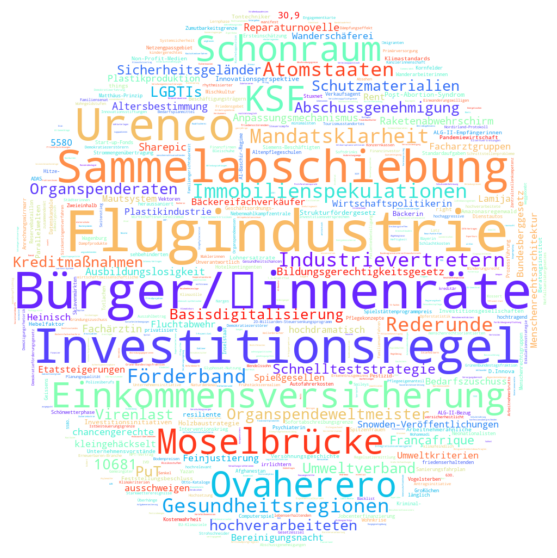

In [9]:
#party = 'AfD'
#party = 'CDU_CSU'
#party = 'SPD'
#party = 'FDP'
party = 'BÜNDNIS 90_DIE GRÜNEN'
#party = 'DIE LINKE'

uw_counter = [wort for wort in reden_gefiltert[party] if wort in uw_all[party]]
counts = Counter(uw_counter)

mask = np.array(Image.open("circle.png"))

# parameters:

wordcloud = WordCloud(width=3200, height=3200,background_color='white', max_words=500, mask=mask,contour_color='#000000',contour_width=0,colormap='rainbow').generate_from_frequencies(counts)


# create image as circle:

fig = plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

# presentate:

plt.show()

## Speichern als Rasterbild

Genügt die Darstellung den Ansprüchen, ist sie als "normales Bild", als Rasterbild im png Format auf dem Dateipfad mit dem jeweiligen Dateinamen am Ende abspeicherbar.

In [32]:
# store to file
wordcloud.to_file(f"../private/wordclouds/wordcloud_{party}.png")
#plt.savefig(f"../private/wordclouds/wordcloud_{party}.png", format="png")

## Speichern als SVG

Für die Zwecke einer qualitätsverlustfreien Vergrößerung der Wordcloud zum pixelfreien Heranzoomen, oder
z.B. Anbringung auf Postern, lässt sich die Darstellung auch als Vektorgrafik in Form einer SVG Datei abspeichern. 
w+ = Datei lesen und schreiben, encoding="utf-8" decodiert die Datei aus dem Skript.

In [10]:
party='BÜNDNIS 90_DIE GRÜNEN'
wordcloud_svg = wordcloud.to_svg(embed_font=True)
f = open(f"../private/wordclouds/wordcloud_{party}.svg","w+", encoding="utf-8")
f.write(wordcloud_svg )
f.close()

## Wordcloud für Parteipaar

Die Funktion erstellt eine Wordcloud aller selbst gewählten Parteipaare.

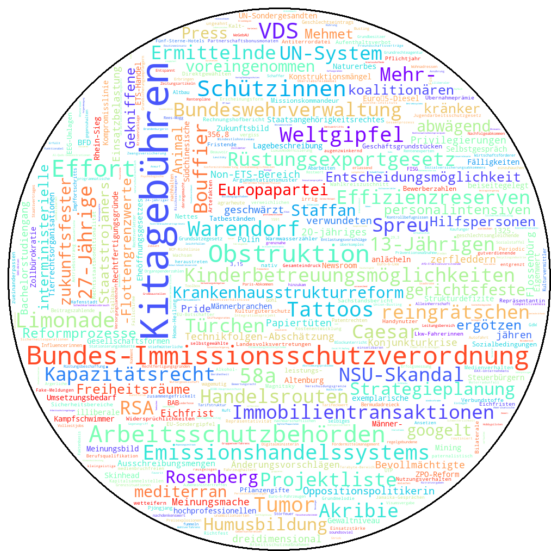

In [11]:
#0 SPD, 1 FDP, 2 CDU/CSU, 3 Linke, 4 Grüne, 5 AfD

uw_counter = [wort for wort in reden_gefiltert['SPD'] + reden_gefiltert['FDP'] if wort in suw_words[0][1]]

counts = Counter(uw_counter)

mask = np.array(Image.open("circle.png"))

# parameters:

wordcloud = WordCloud(background_color='white', max_words=500, mask=mask,contour_color='#000000',contour_width=3,colormap='rainbow').generate_from_frequencies(counts)
#wordcloud = WordCloud(background_color='white', max_words=100, mask=mask).generate_from_frequencies(counts)


# create image as circle

fig = plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

# presentate:

plt.show()

## Speichern als Rasterbild

In [ ]:
wordcloud.to_file(f"../private/wordclouds/wordcloud.png")

## Speichern als SVG

Funktion zum Abspeichern der Wordcloud der Parteipaare als Vektorgrafik.

In [13]:
wordcloud_svg = wordcloud.to_svg(embed_font=True)
f = open("../private/wordclouds/wordcloud.svg","w+", encoding="utf-8")
f.write(wordcloud_svg )
f.close()

## Graph erstellen

Als besondere Darstellungsmethode von (sozilen) Netzwerken als Graph, kann ein Netzwerk ausgegeben werden, das sich mit der Software Gephi visualisieren lässt. Dafür wird im jupyter notebook ein gewichtetes Knoten- und Kantennetzwerk aus den unique words Listen erzeugt. Als erstes werden die Knoten erstellt und mit den leeren Attributen Identifikationsnummer, wird erzeugt durch enumerate-Schleife, dazu Parteinamen und der Größe der parteiangehörigen unique words Liste ausgestattet.
Append fügt der Liste "nodes" jeden Knoten als Item hinzu. Knoten werden befüllt.

In [ ]:
nodes = []
for px,partei in enumerate(uw_all.keys()):
    node = {
        'id' : px,
        'name' : partei,
        'nuw' : len(uw_all[partei])
    }
    nodes.append(node)
    
nodes

Ein ungerichteter Graph wird erstellt, als edgestrength_graph deklariert und bekommt die vorher erstellten Knoten als nodes und noch zu berechnende Links als Kanten des Graphen.
Für die Links bzw. Kanten, werden alle Knoten miteinander verglichen. Es gibt über jede Kante 2 inzidente Knoten, einer als Quelle einer als Ziel, dazu werden Gewichte berechnet, auf Basis der geteilten unique words (suw), die die Kantenstärken bestimmen.
Je mehr geteilte Wörter es gibt, desto stärker ist das Gewicht zwischen den Parteien.
Jede berehnete Kante wird dem Graphen hinzugefügt.

In [ ]:

graph = {
    'directed': False,
    'graph': 'edgestrength_graph',
    'links': [],
    'nodes': nodes
}    

for ix,nodeI in enumerate(graph['nodes']):
    for jx,nodeJ in enumerate(graph['nodes']):
        if jx > ix:
            #print(p1,p2)
            #tmp = return_unique_words([p1,p2],reden_gefiltert) - return_unique_words(p1,reden_gefiltert) - return_unique_words(p2,reden_gefiltert)
            #suw_words[ix][jx] = tmp
            weight = suw[ix][jx]
            #suw[jx][ix] = suw[ix][jx]
            
            source = nodeI['id']
            target = nodeJ['id']
            link_dict = {
                    'source':source,
                    'target':target,
                    'weight':weight       
                }
            graph['links'].append(link_dict)
    
print(graph)

Jeder Knoten wird an Gephi übergeben, bis alle Knoten fertig sind. Dann folgen die Kanten.
Eine XML wird im selben Ordner wie das Notebook abgespeichert.

In [ ]:
graphforgephi = nx.Graph()
for node in graph['nodes']:
    graphforgephi.add_node(node['id'],name = node['name'],nuw = node['nuw']);
    #if(node['name'] == 'Angela Merkel'):
    #    print(node['tops'])

print('nodes done')
for link in (graph['links']):   
    graphforgephi.add_edge(link['source'],link['target'],weight = link['weight'])
print('links done')   
nx.write_gexf(graphforgephi, "graphforgephi.gexf")
print('save done')